In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
from scipy.stats import ttest_ind

from tqdm.notebook import tqdm

In [163]:
suffixes_1 = ["", "_2"]
suffixes_2 = ["", "_kelex"]
dataframes = {}

for suffix_1 in suffixes_1:
    for suffix_2 in suffixes_2:
        subset_pattern = f"./data/result_*t_vs_*f{suffix_2}_15attempts_bsbbert{suffix_1}.tsv"
        # Get a list of files for the current subset pattern:
        subset_files = glob.glob(subset_pattern)
        subset_dataframes = {}
        for file_path in subset_files:
            # Extract num_true and num_false from the file name:
            num_true, num_false = map(int, (file_path.split('_')[1][0], file_path.split('_')[3][0]))
            
            df = pd.read_csv(file_path, sep='\t', decimal=",", header=0)
            subset_dataframes[(num_true, num_false)] = df
        dataframes[(suffix_1, suffix_2)] = subset_dataframes

In [164]:
dataframes[("", "")][(1, 1)]

,constr,definition,examples,positive_predicted,negative_predicted,true_positives,false_positives,false_negatives,true_negatives,precision,recall,f1,accuracy
0,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Er hatte ein Gesicht wie ein Mehlsack .', 'D...",[],"['Er hatte ein Gesicht wie ein Mehlsack .', 'D...",[],[],"['Da merkt kein Mensch , dass wir alle das gle...",['Er hatte ein Gesicht wie ein Mehlsack .'],1.0,1.0,1.0,0.5
1,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Knutschen , bis der Arzt kommt', 'Noch aber ...","['Knutschen , bis der Arzt kommt']",['Noch aber hat keiner der Bundesstaaten eine ...,[],"['Knutschen , bis der Arzt kommt']",['Noch aber hat keiner der Bundesstaaten eine ...,[],0.0,1.0,0.0,0.0
2,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Keine Spur einer Entrüstung , geschweige den...",[],"['Keine Spur einer Entrüstung , geschweige den...",[],[],"['Keine Spur einer Entrüstung , geschweige den...",['Damit drängt sie diese Frauen raus aus der Ö...,1.0,1.0,1.0,0.5
3,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...",['Andererseits fürchteten sie ein einseitiges ...,[],['Andererseits fürchteten sie ein einseitiges ...,[],[],"['Gewiss , Jimmy bildet sich ein , dass sich d...",['Andererseits fürchteten sie ein einseitiges ...,1.0,1.0,1.0,0.5
4,10,"Die ""Negation:NEG_XgeschweigedennY-Konstruktio...","['Weil Funktionäre , Politiker , Ärzte sowie T...","['Weil Funktionäre , Politiker , Ärzte sowie T...",['Der Gottesdienst fängt erst um sieben nach s...,"['Weil Funktionäre , Politiker , Ärzte sowie T...",[],[],['Der Gottesdienst fängt erst um sieben nach s...,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...","['Edwin ist ruhig , noch ruhiger als sonst .',...",['Heute Abend um 22 Uhr 30 wird auf B 1 zwar n...,"['Edwin ist ruhig , noch ruhiger als sonst .']",[],['Heute Abend um 22 Uhr 30 wird auf B 1 zwar n...,"['Edwin ist ruhig , noch ruhiger als sonst .']",[],0.0,1.0,0.0,0.0
3161,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...","['"" Nur "" kommissarisch "" organisiere sein Tea...","['Wichtiger als die Frage , wer sich aus diese...","['"" Nur "" kommissarisch "" organisiere sein Tea...","['Wichtiger als die Frage , wer sich aus diese...",[],[],"['"" Nur "" kommissarisch "" organisiere sein Tea...",1.0,1.0,1.0,1.0
3162,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...",['»Ohne Europa sind viele Fragen nicht mehr se...,['Damit wäre der Geländewagen deutlich günstig...,['»Ohne Europa sind viele Fragen nicht mehr se...,['Damit wäre der Geländewagen deutlich günstig...,[],[],['»Ohne Europa sind viele Fragen nicht mehr se...,1.0,1.0,1.0,1.0
3163,99,"Die ""Komparativ:ADJ-eralsX-Konstruktion"" gehör...",['Wegen eines Fehlers wird er durch einen Schr...,[],['Wegen eines Fehlers wird er durch einen Schr...,[],[],['Rund 45 . 000 Dollar soll der Byton - SUV ko...,['Wegen eines Fehlers wird er durch einen Schr...,1.0,1.0,1.0,0.5


  0%|          | 0/35 [00:00<?, ?it/s]

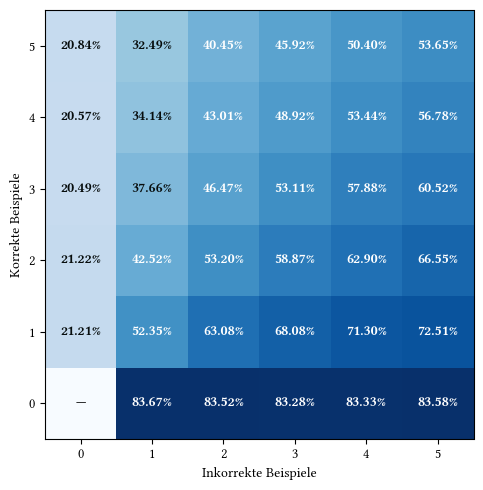

  0%|          | 0/35 [00:00<?, ?it/s]

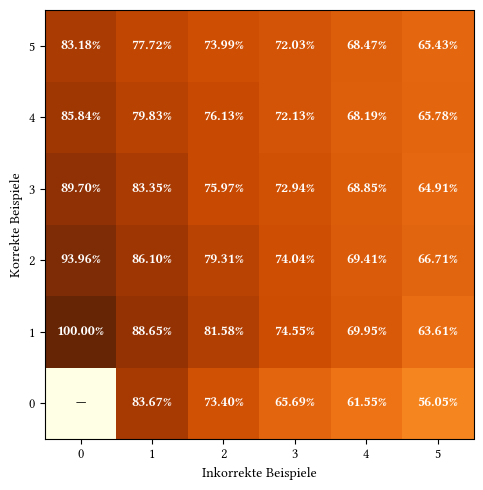

  0%|          | 0/35 [00:00<?, ?it/s]

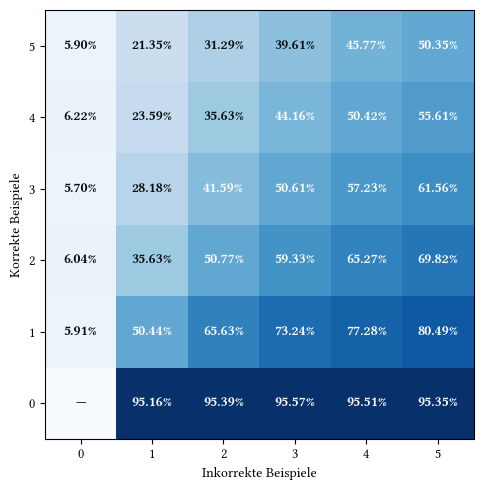

  0%|          | 0/35 [00:00<?, ?it/s]

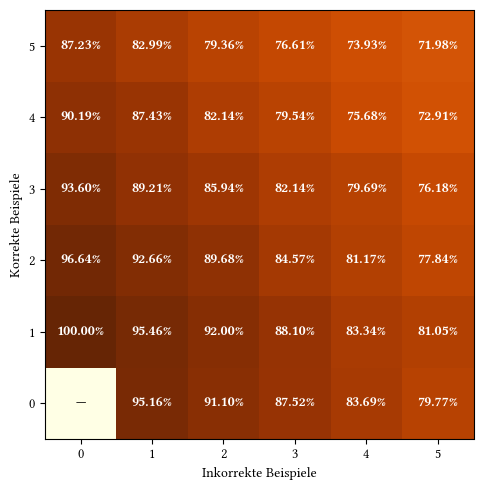

  0%|          | 0/25 [00:00<?, ?it/s]

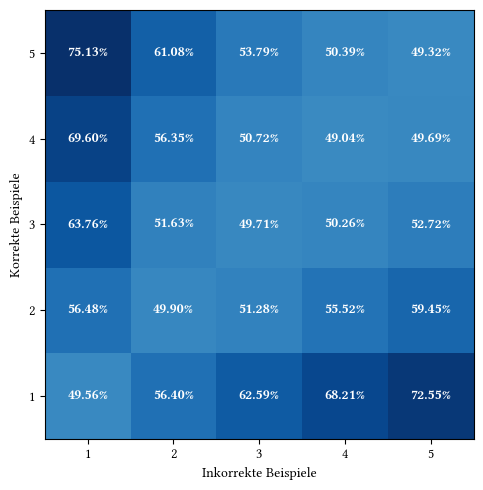

  0%|          | 0/25 [00:00<?, ?it/s]

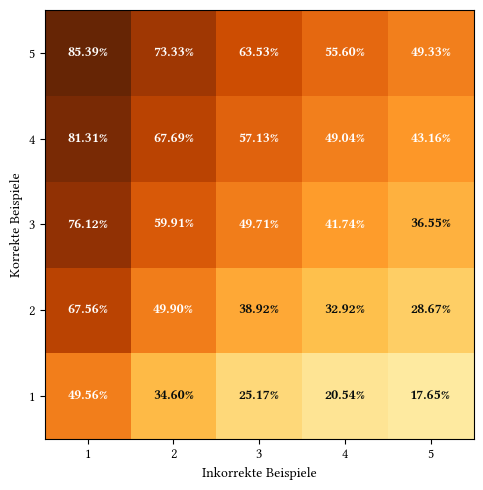

  0%|          | 0/25 [00:00<?, ?it/s]

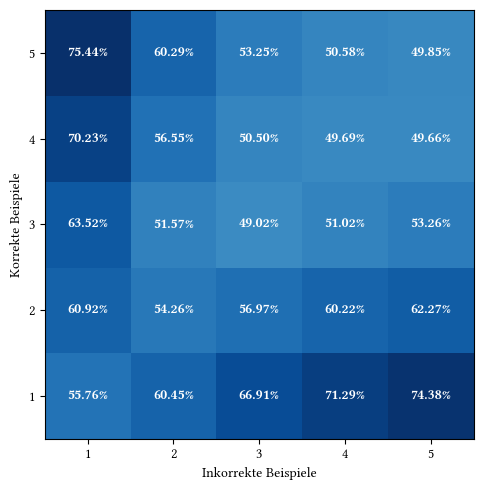

  0%|          | 0/25 [00:00<?, ?it/s]

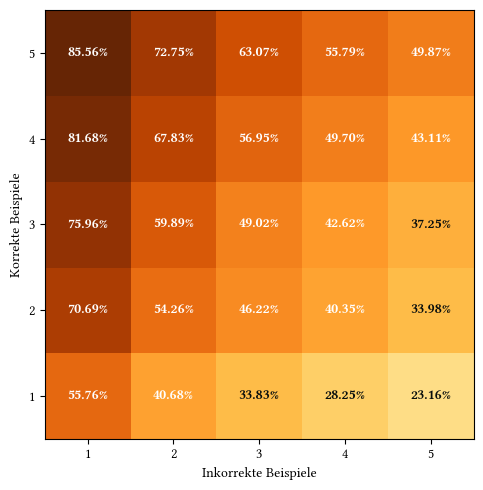

In [165]:
colors_accuracy = "Blues"
colors_f1 = "YlOrBr"
valuefont = {'fontname': 'Libertinus Serif', 'fontweight': 'heavy'}
captionfont = {'fontname': 'Libertinus Serif'}

metrics = [("accuracy", colors_accuracy), ("f1", colors_f1)]
subset_matrices = {}

# Loop over suffixes_1 and suffixes_2
for i, suffix_1 in enumerate(suffixes_1):
    subset_matrices[suffix_1] = []
    for j, suffix_2 in enumerate(suffixes_2):
        # Get the subset dataframes
        subset_dataframes = dataframes[(suffix_1, suffix_2)]
        with_zeros = (0, 1) in subset_dataframes.keys() or (1, 0) in subset_dataframes.keys()

        # Loop over metrics (accuracy, f1)
        metric_matrices = {}
        for k, (metric, cmap) in enumerate(metrics):
            
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))        
            matrices = []
            for num_true, num_false in tqdm(sorted(subset_dataframes.keys())):
                metric_values = subset_dataframes[(num_true, num_false)][metric].values
                matrices.append(metric_values)
            if with_zeros:
                matrices = [np.zeros_like(matrices[0])] + matrices
            metric_matrices[metric] = matrices

            # Create an average matrix
            average_matrix = np.array([np.nanmean(matrix) for matrix in matrices])
            average_matrix = average_matrix.reshape((
                len(set(num_true for num_true, _ in subset_dataframes.keys())),
                len(set(num_false for _, num_false in subset_dataframes.keys()))
            ))
            
            ax.ticklabel_format(useLocale=True)

            ax.imshow(average_matrix, cmap=cmap, vmin=0)
            ax.invert_yaxis()

            for m in range(average_matrix.shape[0]):
                for n in range(average_matrix.shape[1]):
                    if with_zeros and m == n == 0:
                        ax.text(0, 0, "—", ha='center', va='center', color='black', **valuefont)
                    else:
                        value = average_matrix[m, n]
                        ax.text(n, m, f"{value:.2%}", ha='center', va='center', color='xkcd:almost black' if value < 0.4 else 'white', **valuefont)

            ax.set_xticks(range(average_matrix.shape[1]))
            ax.set_xticklabels(sorted(set(num_false for _, num_false in subset_dataframes.keys())), **captionfont)

            ax.set_yticks(range(average_matrix.shape[0]))
            ax.set_yticklabels(sorted(set(num_true for num_true, _ in subset_dataframes.keys())), **captionfont)
            ax.set_xlabel("Inkorrekte Beispiele", **captionfont)
            ax.set_ylabel("Korrekte Beispiele", **captionfont)
            # match (suffix_1, suffix_2):
            #     case ("", "_kelex"):
            #         ax.set_title(f"Unbekannte Anzahl korrekter Beispiele; \nmit Pseudowörtern ({metric.capitalize()})", **captionfont)
            #     case ("_2", "_kelex"):
            #         ax.set_title(f"Bekannte Anzahl korrekter Beispiele; \nmit Pseudowörtern ({metric.capitalize()})", **captionfont)
            #     case ("_2", ""):
            #         ax.set_title(f"Bekannte Anzahl korrekter Beispiele ({metric.capitalize()})", **captionfont)
            #     case _:
            #         ax.set_title(f"Unbekannte Anzahl korrekter Beispiele ({metric.capitalize()})", **captionfont)

            # Adjust layout and show the plot
            plt.tight_layout()
            plt.show()
            #fig.savefig(f"eval_bert{suffix_2}{suffix_1}_{metric}.pdf", bbox_inches='tight')
        subset_matrices[suffix_1].append(metric_matrices)

In [180]:
for suffix_1, metric_list in subset_matrices.items():
    for metric in metric_list[0].keys():
        # Unpack the matrices_list into two matrices
        matrix1, matrix2 = tuple(matrix[metric] for matrix in metric_list)

        for arr1, arr2 in zip(matrix1, matrix2):
            # Remove NaN values
            arr1_no_nan = arr1[~np.isnan(arr1)]
            arr2_no_nan = arr2[~np.isnan(arr2)]
            
            # Perform a paired t-test
            t_statistic, p_value = ttest_ind(arr1_no_nan, arr2_no_nan, equal_var=False)

            print(f"T-test results for suffix_1='{suffix_1}', metric='{metric}':")
            print(f"T-statistic: {t_statistic}")
            print(f"P-value: {p_value}")

            # Check the significance based on the p-value
            alpha = 0.05
            if p_value < alpha:
                print("The difference is statistically significant.")
            else:
                print("The difference is not statistically significant.")

            print("\n")

T-test results for suffix_1='', metric='accuracy':
T-statistic: nan
P-value: nan
The difference is not statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-statistic: -16.46584755052122
P-value: 5.404961524884496e-59
The difference is statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-statistic: -21.588409570326462
P-value: 1.328697039349321e-97
The difference is statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-statistic: -25.034924002633527
P-value: 7.499193350896053e-128
The difference is statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-statistic: -26.493372180562083
P-value: 1.7443707772834575e-141
The difference is statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-statistic: -27.698023912789267
P-value: 2.718252182376086e-153
The difference is statistically significant.


T-test results for suffix_1='', metric='accuracy':
T-st

C:\Users\Tim\.conda\envs\llm-cxg\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
